###### Prepared by Natalie M. Isenberg, 2023

The following code is run to install Julia/the Julia kernel for use in Google Collab. 

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Turing DifferentialEquations StatsPlots LinearAlgebra Distributions MultivariateStats StatsBase Suppressor"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

### Quick Julia Overview

Julia is a high-level, high-performance programming language designed for numerical and scientific computing. It aims to be as easy to use as Python while providing performance comparable to low-level languages like C or Fortran. Julia's syntax is similar to Python in many ways, making it accessible to Python users. In this tutorial, we'll explore some of the basic features of Julia and compare them to their Python counterparts.

##### Installing Julia
Before we begin, make sure you have Julia installed on your system. 
You can download the latest version of Julia from the official website: https://julialang.org/downloads/

In this tutorial, we will learn how to run Julia code in a Jupyter Notebook. If you are familiar with Python and Jupyter, this guide will help you get started with Julia and understand how to use it within the Jupyter environment.

##### Installing Jupyter and Julia Kernel
If you already have Jupyter installed, you can skip this step. 

Otherwise, follow these steps to install Jupyter and the Julia kernel:


##### 1. Install Jupyter using pip (if you have Python installed) or conda:

##### 2. Open the Julia REPL (Read-Eval-Print Loop) by typing *julia* in the terminal.
##### 3. Install the Julia kernel for Jupyter using the following command inside the Julia REPL:

In [23]:
#using Pkg
#Pkg.add("IJulia")

Now, when you create/launch Jupyter notebooks, you will be able to select the Julia kernel to run Julia code.

### Julia Tutorial

Quick "Hello world!" example. In Python, you print text output with *print()*. In julia, you do the following:

In [24]:
println("Hello World!")

Hello World!


##### Variables and Types
In Python, variables are dynamically typed, and you don't need to declare their types explicitly. Julia, however, allows you to specify types for better performance.

In [25]:
# Without Type Annotations (Dynamic Typing)
function compute_sum_dynamic(x, y)
    result = 0
    for i in 1:length(x)
        result += x[i] + y[i]
    end
    return result
end

# With Type Annotations (Static Typing)
function compute_sum_static(x::Vector{Int}, y::Vector{Int})
    result = 0
    for i in 1:length(x)
        result += x[i] + y[i]
    end
    return result
end

# Create arrays for demonstration
x = [1, 2, 3, 4, 5]
y = [10, 20, 30, 40, 50]

# Benchmarking the functions
using BenchmarkTools

# Without Type Annotations
@btime compute_sum_dynamic(x, y)

# With Type Annotations
@btime compute_sum_static(x, y)

println("Static typing is good! Your code will run faster!")


  30.963 ns (0 allocations: 0 bytes)
  11.620 ns (0 allocations: 0 bytes)
Static typing is good! Your code will run faster!


### Uncertainty Quantification Tutorial 

In this notebook, we will implement an ODE model from the literature for a Hes1 protein transcription model that has some interesting oscillatory behavior (see (Liepe et al. 2013, PLOS Comp. Bio.) for more information). 

We will go through a typical Bayesian Inference Workflow, from start to finish. All of the methods we will use apply to any type of problem -- not limited to biology! 

We begin with the Bayesian workflow. First, we must import some useful libraries and define our model...

In [ ]:
# Import libraries
using Turing
using DifferentialEquations
using StatsPlots
using LinearAlgebra
using Distributions
using MultivariateStats
using StatsBase
using Suppressor

# Set a seed for reproducibility if you want
using Random
Random.seed!(11);

: 

You'll likely need to install these libraries. In Julia, you can install libraries using the Pkg module, which is the package manager. To install a library, run the following command in a code cell:

In [27]:
#using Pkg
#Pkg.add("PackageName") # Replace PackageName with the name of the package, like DifferentialEquations

##### Model Specification


The system of equations we want to do parameter estimation with is as follows:

$$ \frac{dm}{dt} = -k_d m + \frac{1}{1 + (\frac{p_2}{P_0})^h} $$
$$ \frac{dp_1}{dt} = -k_d p_1 + \nu m - k_1 p_1 $$
$$ \frac{dp_2}{dt} = -k_d p_2 + k_1 p_1 $$

Where are parameters are: $\theta = [k_1, \nu, h, P_0] $ and $k_d$ is fixed. 
And our model outputs are: $y = [m, p_1, p_2]$ though we consider the total value of proteins $p_1$ + $p_2$.



In [28]:
# Define ODE model
# Implementing Hes1 transcription model from (Liepe et al. 2013, PLOS Comp. Bio.) 

function my_ode_model(du, u, p, t)
    # Define some variable names
    m = u[1]
    p1 = u[2]
    p2 = u[3]

    # Define some parameter names
    kd = 5.0e-4 # The ODE system is stiff w.r.t. this parameter and so it remains fixed
    k1 = p[1]
    ν = p[2]
    P₀ = p[3]
    h = p[4]

    du[1] = -kd * m + (1 / (1 + ((p2+1e-3)/P₀)^h))
    du[2] = -kd * p1 + ν * m - k1 * p1
    du[3] = -kd * p2 + k1 * p1
    
    return nothing
end;

To give a visual of what the model outputs look like under "nominal" conditions, we'll solve and plot the results of the initial value problem.

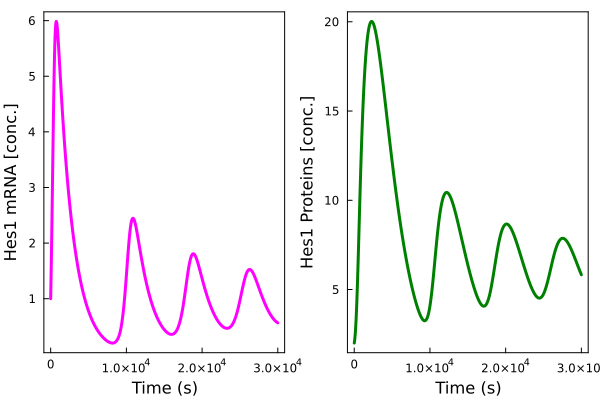

In [29]:
# Specify and solve the initial-value problem
# Define initial-value problem.
u0 = [1.0, 1.0, 1.0]
p = [1.66e-4, 3.33e-3, 0.5, 7.0] # nominal param settings known to cause oscillatory behavior
tspan = (0.0, 30_000)
prob = ODEProblem(my_ode_model, u0, tspan, p)

# Plot simulation.
nominal_res = solve(prob, Tsit5(); saveat=10.0)

# Using subplots
l = @layout [a b]

p1 = plot(nominal_res.t, nominal_res[1,:], legend=false, xlabel="Time (s)", ylabel="Hes1 mRNA [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:magenta)
p2 = plot(nominal_res.t, nominal_res[2,:] .+ nominal_res[3,:], legend=false, xlabel="Time (s)", ylabel="Hes1 Proteins [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:green)
plot(p1, p2, layout = l)

##### "Data Collection"

In the absence of any experimental measurements for the concentrations of Hes1 proteins and mRNA in this pathway, we will generate synthetic experimental data by adding normally distributed noise

$$\frac{dy}{dt} = F(x(t),\theta) + \epsilon,\qquad \epsilon\sim N(0,\sigma^2)$$
$$x(0) = x^0$$

In Julia, the randn() function creates a randomly distributed number with mean 0 and standard deviation 1. 

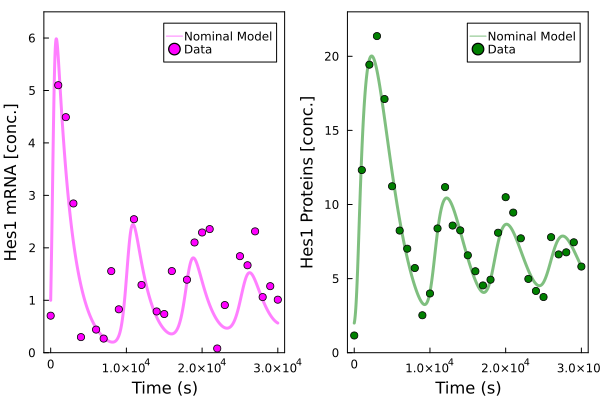

In [30]:
# Generate synthetic experimental data
# Decreasing the saveat parameter leads to fewer saved data points
data_res = solve(prob, Tsit5(); saveat=1000)
σ = 0.8
synthetic_data = Array(data_res) + σ * randn(size(Array(data_res)))

length_time_series = length(data_res.t)

# Plot simulation and noisy observations.
l = @layout [a b]

p1 = plot(nominal_res.t, nominal_res[1,:], legend=false, xlabel="Time (s)", ylabel="Hes1 mRNA [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:magenta, alpha=0.5, label="Nominal Model")
p2 = plot(nominal_res.t, nominal_res[2,:] .+ nominal_res[3,:], legend=false, xlabel="Time (s)", ylabel="Hes1 Proteins [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:green, alpha=0.5, label="Nominal Model")

scatter!(p1, data_res.t, synthetic_data[1,:]; color=:magenta, ylim=(0, 6.5), label="Data")
scatter!(p2, data_res.t, synthetic_data[2,:] .+ synthetic_data[3,:]; ylim=(0, 23),color=:green, label="Data")

plot(p1, p2, layout = l, legend=true)


##### Prior Specification and Prior Predictive Distribution

Now let's look at the prior predictive distribution.

The prior predictive check generates data (model output) according to samples from the priors on each of the parameters and allows us to assess whether the priors are appropriate (do they match the data?)

We draw samples from our priors:

$$\theta^{sim} \sim p(\theta)$$

Then simulate data:

$$y^{sim} \sim  p(y|\theta^{sim})$$

Which results in a simulation from the joint distribution:

$$(y^{sim}, \theta^{sim}) \sim p(y,\theta)$$

Which will give us many $(y^{sim}, \theta^{sim})$ pairs to approximate

$$y^{sim} \sim p(y)$$

  1.302891 seconds (1.17 M allocations: 88.761 MiB, 99.59% compilation time)


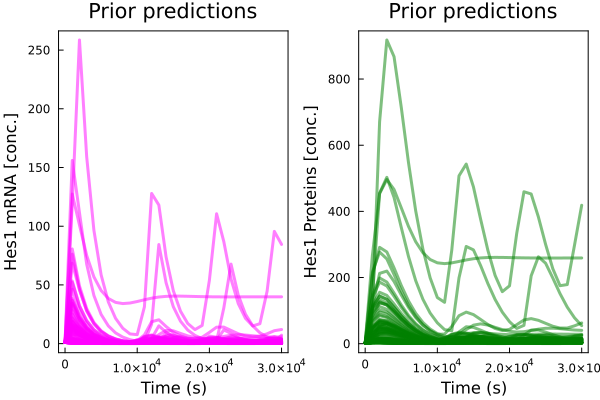

In [31]:
# Let's look at the prior predictive distribution
# We'll draw samples from our prior distributions
N_samp = 100
means = [1.66e-4, 3.33e-3, 0.5, 7.0]
stds = [0.000125, 0.000125, 0.25, 2.75]

# Make distributions
d = truncated.(Normal.(means, stds), lower=1e-8)

# Simulate using Julia's Ensemble methods from their ODE library
prob_func = (prob,i,repeat) -> remake(prob,p=rand.(d))
myproblem = EnsembleProblem(prob, prob_func = prob_func, safetycopy = false)
@time sol = solve(myproblem, Tsit5(), EnsembleThreads(), trajectories=N_samp, saveat=1000)

# Plot some trajectories
p1 = plot()
p2 = plot()
for i in 1:size(sol,3)
    plot!(p1, sol[i].t, sol[i][1,:], legend=false, xlabel="Time (s)", ylabel="Hes1 mRNA [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:magenta, alpha=0.5)
    plot!(p2, sol[i].t, sol[i][2,:] .+ sol[i][3,:], legend=false, xlabel="Time (s)", ylabel="Hes1 Proteins [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:green, alpha=0.5)
end

plot(p1, p2, layout = l, title = "Prior predictions")

It is clear from this prior predictive check that the priors we've selected include parameter settings that lead to different kinds of system dynamic behavior -- some oscillatory and some other dynamics as well. We know the model is stiff with respect to the rate parameters, so we choose relatively narrow priors for these parameters.

We can also zoom in around our data and see if the time series match the data...by design, since we have generated our own synthetic measurements, some of these will match. But in general, if you are working with experimental measurements and you don't see any prior samples leading to similarity in the data, there is likely an issue in the prior or likelihood specification. 

#### Bayesian Inference: Probabilistic Model Specification
In Bayesian inference, we aim to estimate the parameters of a model given observed data. To achieve this, we will use the powerful Turing.jl library in Julia. Turing is a probabilistic programming library that allows us to define our model in a way that closely resembles the mathematical notation we use for probabilistic modeling.

##### The Model
Let's break down the code snippet and understand the components of our probabilistic model:

In [32]:

# Do Bayesian parameter estimation for our model
@model function estimate_Hes1_params(data, prob)
    # Define the prior distributions for our parameters
    k1 ~ d[1]
    ν ~ d[2]
    P₀ ~ d[3]
    h ~ d[4]
    σ ~ InverseGamma(1, 2)

    # Simulate the model
    p = [k1, ν, P₀, h]
    predicted = solve(prob, Rosenbrock23(autodiff=false); p=p, saveat=1000, isoutofdomain = (u,p,t)->any(x->x<0,u))

    # Define the data likelihood of observations (multivariate normal)
    for i in 1:length(predicted)
        # loop over row, for each variable, draw data[var, :] ~ MvN(predicted, ...)
        data[:,i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end

estimate_Hes1_params (generic function with 2 methods)

##### Prior Distributions
In Bayesian inference, we express our prior beliefs about the model parameters using prior probability distributions. In our model, we have four parameters: k1, ν, P₀, and h. The lines k1 ~ d[1], ν ~ d[2], etc., represent that each parameter is drawn from a specific prior distribution, and that the distributions are passed as an array-type. The priors are defined elsewhere in the code (above) and stored in the array d.

We also are inferring the "unknown" data error, σ, and thus define a prior for it as well. 

##### Simulating the Model and Data Likelihood
The code snippet under "# Simulate the model" represents the simulation of the model using the solve function from DifferentialEquations.jl, as mentioned before. This function solves the ordinary differential equations (ODEs) of the model using the specified parameter values p and stores the results in the array predicted.

The next part of the model under "Define the likelihood..." defines the likelihood of observing the data given the simulated model predictions. We use a multivariate normal distribution (MvNormal) to represent the data likelihood. For each time point i in the predicted array, we assume that the observed data follows a multivariate normal distribution.

##### No U-Turn Sampler (NUTS) for Inference
In Bayesian inference, one of the critical steps is sampling from the posterior distribution of model parameters given the observed data. The No U-Turn Sampler (NUTS) is a powerful Hamiltonian Monte Carlo (HMC) sampler that efficiently explores complex posterior distributions. We'll use the NUTS sampler in our Turing model to perform Bayesian inference.

##### What is NUTS?
NUTS is an extension of the traditional HMC algorithm, designed to address some of the challenges faced in high-dimensional parameter spaces. The "No U-Turn" in its name refers to the property that the algorithm efficiently explores the posterior distribution without the need for the cumbersome tuning of the number of steps or step size in the Hamiltonian dynamics.

##### Advantages of NUTS
* Effective Sampling in Complex Posteriors: NUTS leverages the information about the curvature of the target distribution to take more informed and efficient steps during the sampling process. This makes it particularly effective when dealing with complex and multi-modal posteriors.

* Automated Tuning: Unlike some other sampling algorithms, NUTS requires very few tuning parameters. One of the primary tuning parameters is the target acceptance rate, typically set to around 0.65. This means NUTS automatically adjusts its step size during sampling to achieve the desired acceptance rate.

##### Using NUTS in Julia with Turing
In our Julia code, we use the Turing.jl library to specify and define our probabilistic model. Once the model is defined, we can easily sample from the posterior distribution using the NUTS sampler. Here's a high-level overview of the process:

* Model Specification: We define our probabilistic model in Turing, specifying the priors and likelihood based on our problem (see above)

* Sampling: To obtain samples from the posterior distribution, we use the sample function from Turing with the NUTS sampler specified.

In [33]:
# Create the model and sample 
N_samp = 1000
n_chains = 1
model = estimate_Hes1_params(synthetic_data, prob)
@suppress chain = Turing.sample(model, NUTS(0.65), MCMCSerial(), N_samp, n_chains; progress=false);

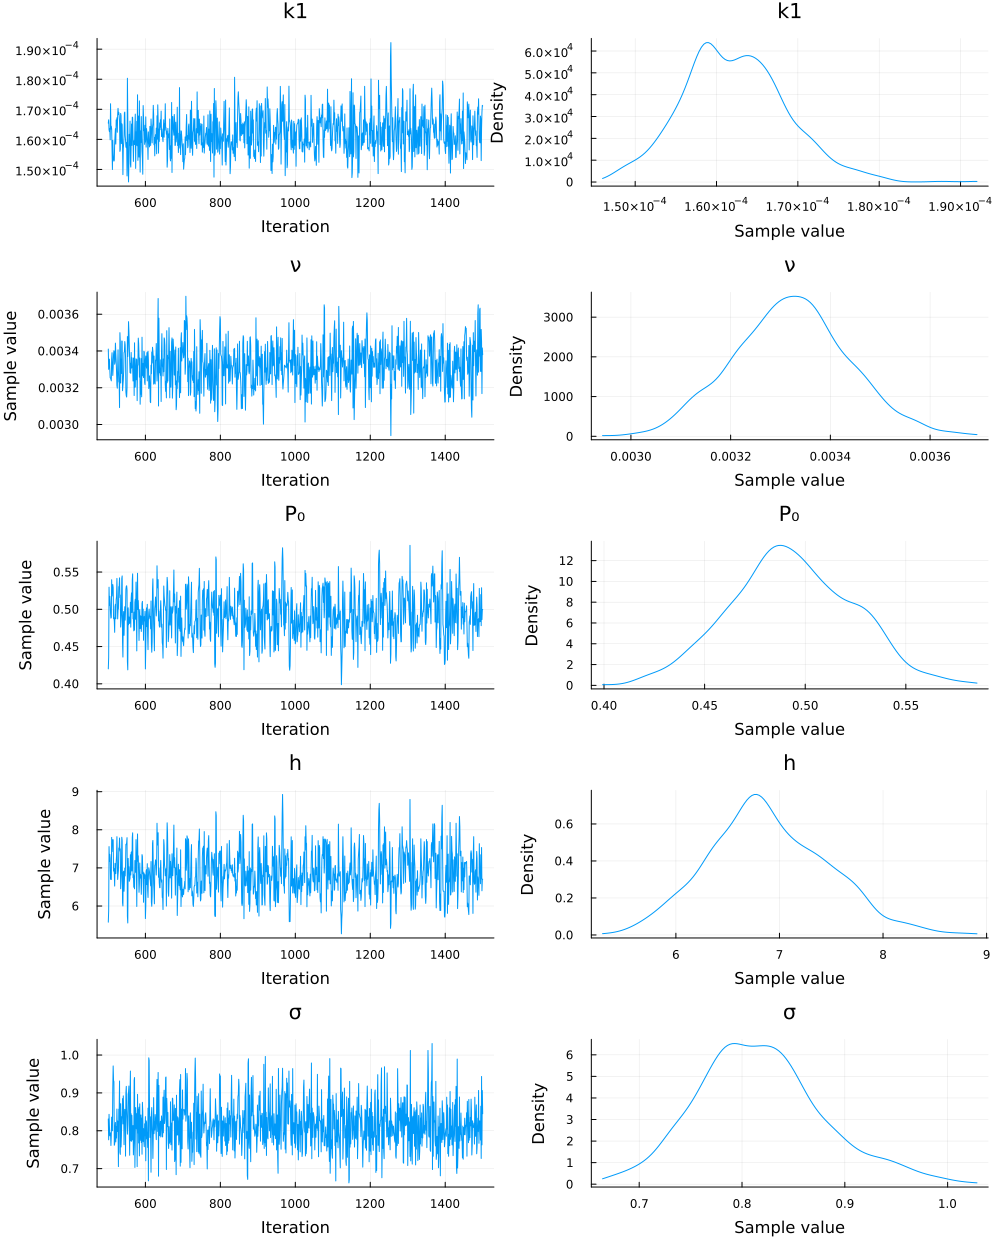

In [34]:
# Plot the chains and posteriors 
posteriors = plot(chain)

##### Analyzing Markov Chains

After performing Bayesian inference and obtaining the Markov Chain Monte Carlo (MCMC) samples using the NUTS sampler, it's essential to analyze the Markov chains to gain insights into the model's behavior and to ensure the reliability of the parameter estimates. Here are some key things to note when analyzing Markov chains:

1. Convergence
    * Trace Plots are shown on the left above. The trace plot shows how each parameter evolves over the course of the MCMC sampling process. Look for stability and no obvious trends, which indicate that the chain has converged.

    * Gelman-Rubin Statistic (R-hat) is a measure of convergence for multiple chains. It compares the within-chain variance to the between-chain variance, and values close to 1 suggest convergence. A common threshold for convergence is R-hat < 1.1 for all parameters.
2. Autocorrelation
    Markov chains are often *autocorrelated*, meaning that the value of a parameter at one iteration is dependent on its previous value. High autocorrelation can slow down convergence and may require more samples for accurate estimates. Plotting the autocorrelation function (ACF) of the chain can help identify potential issues.
3. Effective Sample Size (ESS)
    Effective Sample Size (ESS) measures the effective number of independent samples in the Markov chain. It accounts for autocorrelation and is often much lower than the actual number of iterations. Higher ESS values indicate more efficient sampling, while low ESS suggests the need for more samples.
    
If you want to look the R-hat value and ESS, print out the summary statistics for your chain:

In [35]:
display(chain) # look at the rhat and ess columns!

Chains MCMC chain (1000×17×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 69.44 seconds
Compute duration  = 69.44 seconds
parameters        = k1, ν, P₀, h, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          k1    0.0002    0.0000     0.0000    0.0000   580.3866    1.0052     ⋯
           ν    0.0033    0.0001     0.0000    0.0000   533.1957    1.0032     ⋯
          P₀    0.4934    0.0304     0.0010    0.0015   501.5421    0.9991     ⋯
           h    6.8933    0.5785     0.0183    0.0281   517.1924    0.9990     ⋯
           σ    0.8178    0.0621     0.0020    0.0023   9

And here's a little code for plotting the autocorrelation for your chain

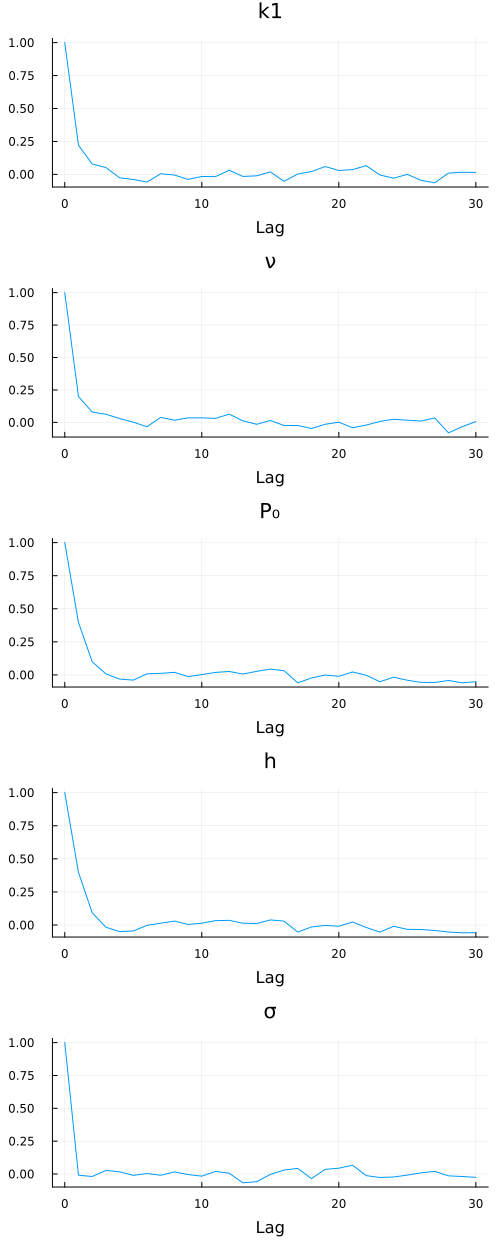

In [36]:
autocor(chain)
display(autocorplot(chain))

#### Posterior Checks: Examining Uncertainty in Model Predictions
After obtaining the posterior samples for the model parameters using the NUTS sampler, we want to understand the uncertainty in our posterior model predictions. To achieve this, we will sample the ODE model predictions by solving our system of differential equations over the posterior distribution of the parameters obtained from the MCMC sampling.



##### Estimating Pointwise 95% Credible Interval
To visualize the uncertainty in our model predictions, we will create "ribbon plots" that display the 95% credible interval (equivalent to a confidence interval) around the mean model prediction. The ribbon represents the range within which we expect our model predictions to fall with a high degree of confidence, considering the uncertainty in the parameter estimates.

The function **estimate_credible_interval(chain, pred_func)** is designed to create these ribbon plots. Here's how it works:

1. Mean Posterior Model Prediction
    We first calculate the mean posterior model prediction by taking the mean of the posterior samples for each parameter (k1, ν, P₀, and h). We then use these mean parameter estimates to solve our differential equations, resulting in the mean posterior model prediction.

2. Model Predictions over Posterior Samples
    Next, we sample the ODE model predictions for each posterior sample of the parameters. For each posterior sample, we solve the system of differential equations using the corresponding parameter values. These model predictions are collected and stored in the model_predictions array.

3. Compute 95% Confidence Intervals
    We calculate the 95% confidence intervals for the posterior model predictions by finding the 2.5th and 97.5th percentiles of the model predictions along each time point. This range corresponds to the bounds of the credible interval around the mean model prediction.

4. Plotting the Ribbon Plots
    Using the Plots.jl library, we create ribbon plots for both the mRNA and protein concentrations. The ribbon plots show the credible interval around the mean posterior model prediction. Additionally, we overlay the nominal model (with default parameter values) as dashed lines and the synthetic noisy measurement data as scatter points.

In [37]:
# Function for making nice ribbon Plots given a chain of samples and prediction function
function estimate_credible_interval(chain, pred_func)
    # Get posterior MEAN model prediction to plot (at the mean posterior estimates of the parameters)
    param_predictions = [Turing.mean(chain[:k1]), Turing.mean(chain[:ν]), Turing.mean(chain[:P₀]), Turing.mean(chain[:h])]
    post_prediction = solve(prob, Tsit5(); p=param_predictions, saveat=1000)  
    
    # Collect solutions over samples posterior parameter values
    model_predictions = Any[]
    for p in eachrow(Array(posterior_samples))
        sol = pred_func(p)
        push!(model_predictions, sol)
    end
    
    pred_mRNA = hcat([model_predictions[i][1,:] for i in 1:length(model_predictions)]...)
    pred_proteins = hcat([model_predictions[i][2,:] + model_predictions[i][3,:] for i in 1:length(model_predictions)]...)

    mean_mRNA = mean(pred_mRNA, dims=1)'
    mean_proteins = mean(pred_proteins, dims=1)'

    # Compute 95% confidence intervals for the posterior predictions 
    lo_mRNA = mapslices(x->quantile(x,0.025), pred_mRNA, dims=1)'
    hi_mRNA = mapslices(x->quantile(x,0.975), pred_mRNA, dims=1)'
    lo_proteins = mapslices(x->quantile(x,0.025), pred_proteins, dims=1)'
    hi_proteins = mapslices(x->quantile(x,0.975), pred_proteins, dims=1)'

    # Plot simulation and noisy synthetic measurement data
    p1 = plot(post_prediction.t, post_prediction[1,:], legend=false, ribbon=(mean_mRNA-lo_mRNA,hi_mRNA-mean_mRNA), color=:pink, alpha = 0.5, xlabel="Time (s)", ylabel="Hes1 mRNA [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:magenta, label="Posterior model")
    p2 = plot(post_prediction.t, post_prediction[2,:] .+ post_prediction[3,:], legend=false, ribbon=(mean_proteins-lo_proteins,hi_proteins-mean_proteins), color=:lightgreen, alpha = 0.5, xlabel="Time (s)", ylabel="Hes1 Proteins [conc.]", grid=false, framestyle=:box, linewidth=3, linecolor=:green, label="Posterior model")
    plot!(p1, nominal_res.t, nominal_res[1,:],linecolor=:grey, linewidth=3, label="Nominal Model", linestyle=:dash)
    plot!(p2, nominal_res.t, nominal_res[2,:] .+ nominal_res[3,:], linecolor=:grey, linewidth=3, label="Nominal Model", linestyle=:dash)
    
    scatter!(p1, data_res.t, synthetic_data[1,:]; color=:magenta, label="Data")
    scatter!(p2, data_res.t, synthetic_data[2,:] .+ synthetic_data[3,:]; color=:green, label="Data")

    plot(p1, p2, layout = l, legend=true)
end


estimate_credible_interval (generic function with 1 method)

So now that we understand what's happening here, let's make the plots!

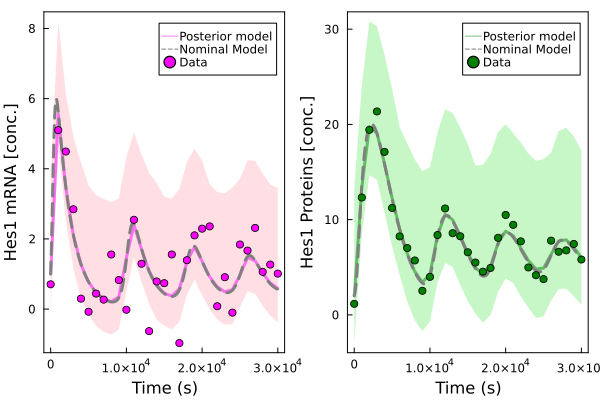

In [38]:
function solve_model(p)
    sol = solve(prob, Tsit5(); p=p, saveat=1000)
    return sol
end

# Sample the posterior distribution over model predictions
posterior_samples = Turing.sample(chain[[:k1, :ν, :P₀, :h]], 10; replace=false)
estimate_credible_interval(posterior_samples, solve_model)


#### Posterior Predictive Distribution: Incorporating Measurement Uncertainty

In the previous section, we created "ribbon plots" to visualize the 95% credible interval around the mean model prediction based on our inferred posterior model. However, it's essential to recognize that the 95% credible interval doesn't necessarily capture 95% of the observed data. This is because the analysis overlooked an essential part of the statistical model: the stochastic random error model or the measurement noise.

To address this limitation and quantify the uncertainty in the observed data, we need to consider a more comprehensive distribution called the *posterior predictive distribution*. The posterior predictive distribution accounts for both the uncertainty in the model parameters (represented by the parameter posterior) and the stochastic variability (measurement noise) in the data.

Let's assume data we've used in inference so far is $y$, and new unobserved data is $y'$.

What we want to use is the **posterior predictive distribution**, defined as:

$$p(y'|y) = \int p(y'|\theta) p(\theta|y)\,d\theta$$

The first factor in the integrand ($p(y'|\theta)$) is the likelihood of new data, conditional on the (unknown) deterministic model parameters. The second factor ($p(\theta|y)$) is the parameter posterior. We marginalize out the parameter uncertainty ($\theta$) to get the distribution of *new* data ($y'$), conditional on (fitting to) the observed data ($y$).

##### Sample-Wise Estimation of Posterior Predictive Distribution

To compute the posterior predictive distribution in practice, we resort to a sample-wise estimation approach using the Markov chain obtained from MCMC sampling. We draw samples from the parameter posterior (our Markov chain) and, for each sample, we conditionally sample from the likelihood. This involves evaluating our ODE model at the sampled parameter values and adding a random draw of independent and identically distributed (iid) Gaussian noise, which represents the measurement noise from our statistical model.

In [39]:
# Let's just define a function to make this noisy posterior evaluation for us
function sample_posterior_predictive(θ)
    model = solve(prob, Tsit5(); p=θ, saveat=1000)
    noise = σ*randn(length(model.t))
    pred = hcat(model[1,:] .+ noise, model[2,:] .+ noise, model[3,:] .+ noise)'
    return pred
end

sample_posterior_predictive (generic function with 1 method)

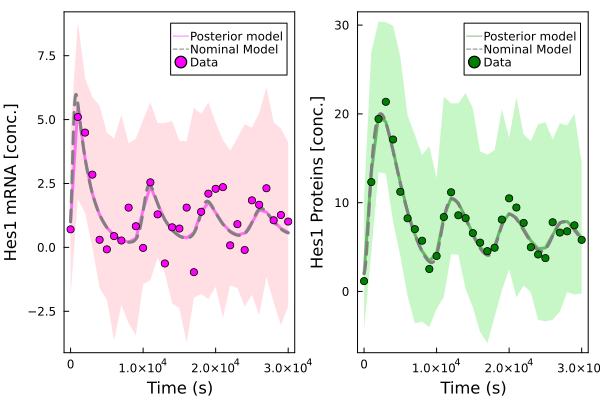

In [40]:
# Add posterior predictive and compare to posterior model predictions, ideally 95% of predictions will encompass data...
σ = 1.5 # The sigma from our statistical model 
estimate_credible_interval(posterior_samples, sample_posterior_predictive)


##### Parameter Correlation Analysis

In Bayesian inference, understanding the relationships between model parameters is crucial for gaining insights into the underlying system. We can assess the correlations between the input parameters using the Markov Chain Monte Carlo (MCMC) samples obtained during the Bayesian inference process.

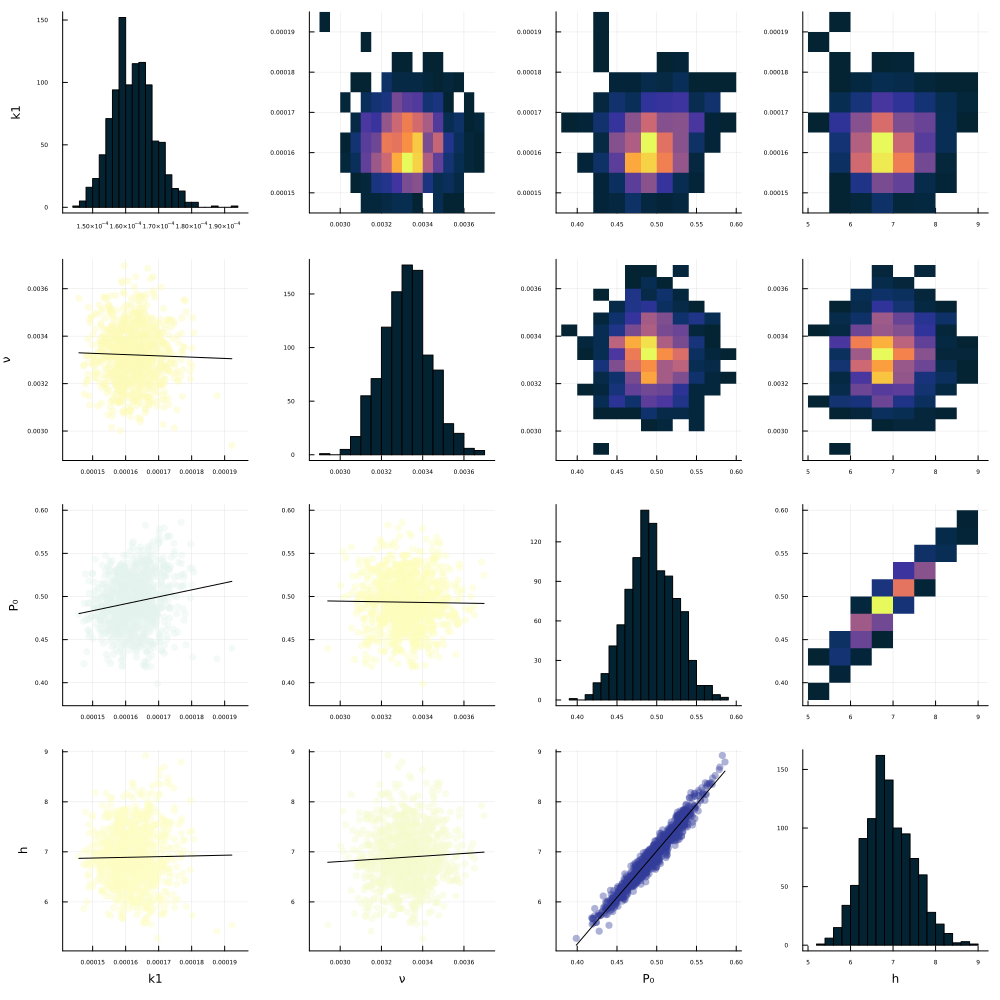

In [41]:
corrplot(Array(chain[[:k1, :ν, :P₀, :h]]), label=["k1", "ν", "P₀", "h"], tickfontsize=4, guidefontsize=8, formatter=:plain, size=(1000,1000), fc=:thermal)

In the bottom left plots, we have scatter plots of the points samples in the MCMC chain. The diagonal plots are 1D histograms for the distributions of each parameter's posterior, and the right corner plots are 2D histograms. 

The marker color in the scatter plots reveals the degree of correlation. 
Here, positive correlations are blue, neutral are yellow and negative are red. In the 2d-histograms, the color gradient shows the frequency of points in that bin, where lighter colors are higher frequency. 

From these plots we learn that these is a large degree of positive correlation between the $h$ and $P_0$ parameters in our model, as well as a very slight positive correlation between $P_0$ and $k_1$.